<a href="https://colab.research.google.com/github/workingbetter/ITNPAI1/blob/main/ITNPAI1_3071806.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

#University of Stirling - Spring 2023

## ITNPAI1 - Deep Learning for Vision and NLP (2022/3)

---

# ITNPAI1 Project
MICHAEL BOGALE
3071806

---
# 1. Problem Defination
## Image Classification problem
Creating a deep learning model that classifies cars and trees on image dataset collected from Areal imaging on Google Earth Pro and testing its performance.
## Dataset collected 
Addis Ababa 

Stirling

---
# 2. Github repository
repository created

###Invitation sent usernames

1. sandyCarmichael
2. vak000
3. jeferssonalex

---
# 3. Dataset Creation
##Created dataset containing 400 images on each subset
## Addis Ababa Labeled Images
####Addis Ababa Car (400)
####Addis Ababa Tree (400)
####Addis Ababa Neither (400)
## Stirling Labeled Images
####Stirling Car (400)
####Stirling Tree (400)
####Stirling Neither (400)

The images are extracted from Google Earth Pro

The images are collected from Addis Ababa and Stirling. 

*Images taken at eye altitude of 200 meter from the surface of the earth on march 2023.*



---
# 4. Dataloader
1. Pre processing
2. Cleaning
3. De-noising

Importing necessary modules

In [ ]:
# Importing necessary libraries and modules
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, GaussianBlur
import os
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import random_split


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Pre processing
specifing locations of our dataset


In [ ]:
# Directory path of image datasets
stir_tree = '/content/drive/MyDrive/Deep learning/dataset11/dataset/Stirling_Tree'
stir_car = '/content/drive/MyDrive/Deep learning/dataset11/dataset/Stirling_Car'
addis_tree = '/content/drive/MyDrive/Deep learning/dataset11/dataset/Addis_Ababa_Tree'
addis_car = '/content/drive/MyDrive/Deep learning/dataset11/dataset/Addis_Ababa_Car'

Creating label dataframe for our datasets 

Extracting it to a csv file format

In [ ]:
"""the dataset is locate on my drive therefore it can not be accessed directly from github
may be i will find a way to access the zip file in github later """

# A function for generating dataframe of lables and extracting csv
def labeler_csv(path):
  data = []
  for folder in os.listdir(path):
      for file in os.listdir(os.path.join(path, folder)):
        if file != '.DS_Store':
          data.append([os.path.join(file), folder])
  df = pd.DataFrame(data, columns=['filename', 'label'])
  # df.to_csv(f'/content/drive/MyDrive/{path}.csv', index=False)
  return(df.head(2))

In [ ]:
display(labeler_csv(stir_tree))

,filename,label
0,image1_15x1.jpg,0
1,image1_15x2.jpg,0


### Data cleaning and preprocessing before starting building the model is necessary to ensure it is in a suitable format for training.

Resizing the images to have uniform dimension is necessary.

Converting the images to pytorch tensor format.

The transformations applied to the images include resizing the images to a uniform size of 224x224 pixels using the Resize transform and converting the images to PyTorch tensors using the ToTensor transform.

*The dataset contains images that are located in two folders labeled '0' and '1'. The dataset class loads the image paths and labels from the folders and applies some transformations to the images before returning them as PyTorch tensors along with their corresponding labels.*

This code provides a basic framework for loading a custom dataset of images and applying some standard transformations to them before feeding them into a PyTorch model for training or inference.

In [ ]:
# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize the images to 224x224 to have uniformity
    transforms.ToTensor(), # convert the images to PyTorch tensors
])

# Define the dataset class
class CustomDataset(torch.utils.data.Dataset):
    # initializes the dataset object and loads the image paths and labels from the two folders
    def __init__(self, root_dir):
        self.root_dir = root_dir
        # image paths
        self.image_paths = []
        # label path
        self.labels = []
        
        # Load the image paths and labels from the two folders
        for label in ['0', '1']:
            folder_path = f'{root_dir}/{label}/'
            for image_path in os.listdir(folder_path):
                self.image_paths.append(f'{folder_path}/{image_path}')
                self.labels.append(int(label))

    # Number of images    
    def __len__(self):
        return len(self.image_paths)
    # Loading individual images with lables
    def __getitem__(self, idx):
        # Load the image and apply the transformations
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image = transform(image)
        
        # Get the label of the image
        label = self.labels[idx]
        
        return image, label

plotting code taken from extra tuitorials

In [ ]:
# Define plotting function
def plot_dataset(positive, negative, dataset):
    labels_map = {
        0: negative,
        1: positive
    }
    # Selecting some images for preview
    figure = plt.figure(figsize=(8, 5))
    cols, rows = 5, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item() # Randomly selected
        #print(sample_idx)
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        new_img = np.transpose(img, (1, 2, 0))
        plt.imshow(new_img.squeeze())
    plt.show()

Creating a dataloader object by passing the dataset object and other parameters to DataLoader.

Iterating over the dataloader object in the training or testing loop to get batches of data and labels

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html


### Datasets and Dataloaders for
1. Stirling Tree
2. Stirling Car
3. Addis Ababa Tree
4. Addis Ababa Car

Image transformation to tensor is applied on dataset

In [ ]:
# Create the dataset and dataloader objects

# Datasets 
stir_tree_dataset = CustomDataset(stir_tree)
stir_car_dataset = CustomDataset(stir_car)
addis_tree_dataset = CustomDataset(addis_tree)
addis_car_dataset = CustomDataset(addis_car)

#dataloader = DataLoader(stir_tree_dataset, batch_size=64, shuffle=True)

### Stirling Tree

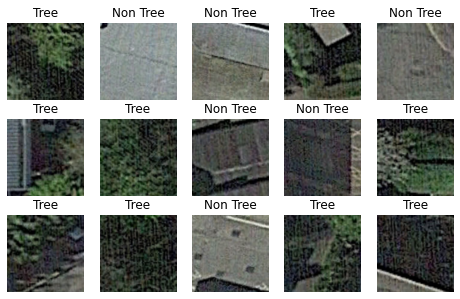

Stirling Tree random images


In [ ]:
plot_dataset("Tree", "Non Tree",stir_tree_dataset)
print('Stirling Tree random images')

### Stirling Car

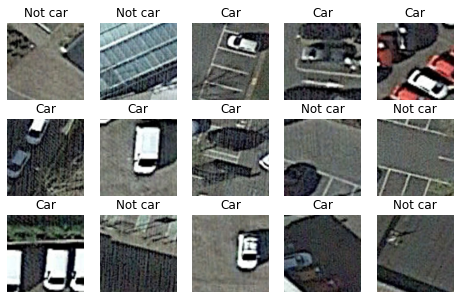

Stirling Car random images


In [ ]:
plot_dataset("Car", "Not car",stir_car_dataset)
print('Stirling Car random images')

### Addis Ababa Tree

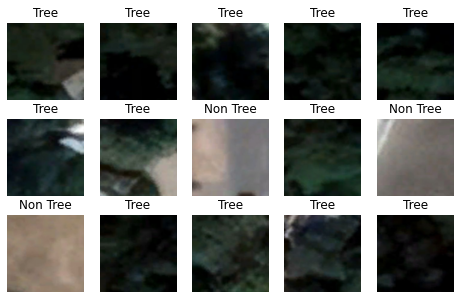

Addis Ababa Tree random images


In [ ]:
plot_dataset("Tree", "Non Tree",addis_tree_dataset)
print('Addis Ababa Tree random images')

### Addis Ababa Car

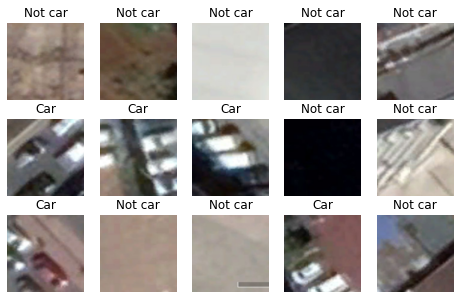

Addis Ababa Car random images


In [ ]:
plot_dataset("Car", "Not car", addis_car_dataset)
print('Addis Ababa Car random images')

### Data Denoising and Augmentation
Adding denoising 
data augmentation.

Normalizing pixel values to lie between 0 and 1 using the transforms.Normalize() function in PyTorch.

RandomHorizontalFlip, RandomRotation helps to prevent over fitting 

*This code defines a set of image transformations to be applied to a dataset of images before feeding them into a deep learning model. The transformations include resizing the images to a uniform size, random horizontal flipping, random rotation, Gaussian blurring, normalization, and converting the images to PyTorch tensors.*

In [ ]:
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, GaussianBlur
# Define the transformations to be applied to the images
# Transforms is a function imported from torchvision
transform = transforms.Compose([
    transforms.Resize((224, 224)), #resizing the images to a uniform size of 224x224 pixels.
    transforms.RandomHorizontalFlip(p=0.5),  # horizontal flip with probabity of 0.5
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(), # converting images to pytorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalize the images
])

# 5. Proposed Solution

Splitting the dataset into train and test sets

In [ ]:

def Train_Test_split(dataset, random_state=None):
    if random_state is None:
        random_state = 3071806
        
    train_ratio = 0.8
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    test_size = total_size - train_size

    train_set, test_set = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(random_state))
    return(train_set, test_set)


### Train Test Dataloaders

In [ ]:
# Dataloader
# stir_dataloader = DataLoader(stir_tree_dataset, batch_size=64, shuffle=True)


In [ ]:
# Stirling Tree train test split
ST_train_dataloader = DataLoader(Train_Test_split(stir_tree_dataset)[0], batch_size=64, shuffle=True)
ST_test_dataloader = DataLoader(Train_Test_split(stir_tree_dataset)[1], batch_size=64, shuffle=False)

# Stirling Car train test split
SC_train_dataloader = DataLoader(Train_Test_split(stir_car_dataset)[0], batch_size=64, shuffle=True)
SC_test_dataloader = DataLoader(Train_Test_split(stir_car_dataset)[1], batch_size=64, shuffle=False)

# Addis Ababa Tree train test split
AT_train_dataloader = DataLoader(Train_Test_split(addis_tree_dataset)[0], batch_size=64, shuffle=True)
AT_test_dataloader = DataLoader(Train_Test_split(addis_tree_dataset)[1], batch_size=64, shuffle=False)

# Addis Ababa Car train test split
AC_train_dataloader = DataLoader(Train_Test_split(addis_car_dataset)[0], batch_size=64, shuffle=True)
AC_test_dataloader = DataLoader(Train_Test_split(addis_car_dataset)[1], batch_size=64, shuffle=False)



creating a model

In [ ]:
num_classes = 2 # 2 catagories 

# initilizing ResNet-18 model
model = models.resnet18()

# replaces with new layer containing our first num classes (tree, not tree)
model.fc = nn.Linear(model.fc.in_features, num_classes)

## This is training a deep learning model from scratch on a new dataset rather than pretrained models

Defining model loss function and optimizer

This code initializes a cross-entropy loss function and an Adam optimizer for a PyTorch deep learning model.

criterion function computes the cross-entropy loss between the predicted class probabilities and the true class labels.

optimizer function initializes the Adam optimizer with a learning rate of 0.001

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training function on train split data

In [ ]:
def pytorch_train(train_dataloader):
    num_epochs = 10
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        epoch_loss = running_loss / len(train_dataloader)

        print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {train_acc:.2f}%')


In [ ]:
def pytorch_test(test_dataloader):
  
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_dataloader)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')


# Stirling Tree Trained

training our model on training dataset

In [ ]:
pytorch_train(ST_train_dataloader)

Epoch: 1/10, Loss: 0.3608, Accuracy: 85.94%
Epoch: 2/10, Loss: 0.0969, Accuracy: 96.72%
Epoch: 3/10, Loss: 0.1104, Accuracy: 96.41%
Epoch: 4/10, Loss: 0.1239, Accuracy: 95.78%
Epoch: 5/10, Loss: 0.0955, Accuracy: 97.19%
Epoch: 6/10, Loss: 0.1262, Accuracy: 95.94%
Epoch: 7/10, Loss: 0.0782, Accuracy: 97.19%
Epoch: 8/10, Loss: 0.0994, Accuracy: 96.41%
Epoch: 9/10, Loss: 0.0792, Accuracy: 96.88%
Epoch: 10/10, Loss: 0.0935, Accuracy: 96.25%


Evaluating the model on test dataset

In [ ]:
# Stirling Tree Test
pytorch_test(ST_test_dataloader)

Test Loss: 0.6665, Test Accuracy: 81.25%


In [ ]:
# Addis Ababa Tree test
pytorch_test(AT_test_dataloader)

Test Loss: 0.3383, Test Accuracy: 89.38%


# Stirling Car trained

In [ ]:
# Stirling car train
pytorch_train(SC_train_dataloader)


Epoch: 1/10, Loss: 0.7713, Accuracy: 73.59%
Epoch: 2/10, Loss: 0.4316, Accuracy: 80.94%
Epoch: 3/10, Loss: 0.3782, Accuracy: 84.69%
Epoch: 4/10, Loss: 0.3122, Accuracy: 86.88%
Epoch: 5/10, Loss: 0.2829, Accuracy: 87.34%
Epoch: 6/10, Loss: 0.2495, Accuracy: 90.47%
Epoch: 7/10, Loss: 0.2328, Accuracy: 90.47%
Epoch: 8/10, Loss: 0.2434, Accuracy: 90.31%
Epoch: 9/10, Loss: 0.1981, Accuracy: 91.56%
Epoch: 10/10, Loss: 0.2081, Accuracy: 92.50%


In [ ]:
# Stirling Car Test
pytorch_test(SC_test_dataloader)

Test Loss: 0.2482, Test Accuracy: 90.62%


In [ ]:
# Addis Ababa Car Test
pytorch_test(AC_test_dataloader)

Test Loss: 2.0065, Test Accuracy: 55.00%


In [ ]:
lt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(torch.transpose(images[i], (0, 2, 1)).numpy().squeeze(), cmap='gray')
    plt.title('Label: {}'.format(labels[i].item()))
plt.show()